### Exploratory data analysis and modelling exercise  for solving multi label text classification

In this jupyter notebook we will be exploring a judicial law dataset and build multi-label classification models to solve the label automation problem

Below notebook is divided into below 4 sections: <br>
    Step1. Reading data, understanding and extracted text from nested hierarchy structure of law documents <br>
    Step2. Data exploration and descriptive stats <br>
    Step3. Data preprocessing <br>
    Step4. Modelling  <br>
    Step5. Evaluation of multi labels prediction

In [68]:
#import packages
import os
import yaml
from sklearn.model_selection import train_test_split

#custom modules
from src.data.generate_dataset import * #we need all functions to be imported
from src.data.preprocess import preprocess_data,word_counts
from src.visualization.visualize import * #we need all functions to be imported
from src.models.build_model import *

In [71]:
#read data from path specified in config
config_path = './config.yaml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [6]:
output_path = config['DATA']['output_path']

### Step 1: Reading data into memory and understanding nested structure of documents

In [7]:
#Load json string data into memory
lines = read_txt(config['DATA']['input_path'])

The structure of Law document data is quite complex. Below is the nested hierarchy structure for a single document:

```bash
|── document ID                
|    |── labels                                          <- May contains multiple labels
│        |-Federal laws
|        |-Civil rights
│    |── sections                                        <- May contain one or more sections
│         |── <section1>
|                 |-headtext                             <- heading of the section
|                 |-paragraphs                           <- May contain one or more paragraphs
|                      |-<paragraph1 text>
|                      |-<paragraph2 text>
```

I have written parser functions (present in src/data/generate_data.py) to extract texts for modelling.
1. label_parser function will extract labels from above nested structure
2. paragraph_parser function will extract text required for modelling purpose. More on this in subsequent cells of this notebook

In [8]:
#There are ~20k lines/documents
print('There are {} documents'.format(len(lines)))


#Parse document id and labels into a dataframe
label_df = label_parser(lines)
#there are a few missing labels in the data. I have replaced with "None" as identifier within label_parser fn

There are 20020 documents


In [9]:
#label_parser function unnests the labels across rows such that one documentId may have multiple labels as rows
#Since a document may have one or more labels associated with it, label_df.shape > 20K
label_df.shape

(31830, 2)

In [1]:
label_df.head()

### Step 2: Data exploration and descriptive stats

#### Below are steps taken around Data exploration and descriptive stats:
        2.1 Basic descriptive stats 
        2.2 Labels distribution and cumsum distribution
        2.3 Documents vs # of labels distribution 
        2.4 Extract paragraphs from nested structure
        2.5 Average word length distribution in text paragraphs across labels
        2.6 Word cloud distribution

###### Step 2.1 Basic descriptive stats

In [4]:
#Distinct number of labels
print('Distinct number of labels:')
label_df.loc[label_df['labels']!='None']['labels'].nunique()

Distinct number of labels:


In [5]:
#Total number of documents with missing labels:
print('Total number of documents with missing labels:')
label_df.loc[label_df['labels']=='None']['documentId'].nunique()

Total number of documents with missing labels:


In [14]:
#Removing documents with blank labels for current exploration
label_df = label_df.loc[label_df['labels']!='None']

In [6]:
##~19k documents remain to model on
print('Removing blank labels we have below number of unique documents:')
label_df['documentId'].nunique()

Removing blank labels we have below number of unique documents:


#### Step 2.2 Get distribution and Cumulative distrbution of documents across Labels

In [16]:

cumsm_df = get_cumsum_distribution(label_df,'labels')
cumsm_df=cumsm_df.reset_index()
cumsm_df.columns = ['labels','# of documents','Cum sum','Cum sum %']

In [7]:
cumsm_df[:20]

As seen above, top 10 labels cover ~80% of the documents (cum sum %)

In [20]:
#Save Label-Document distrbution as one of the outputs
cumsm_df.to_csv(output_path+'//Label_document_distribution_stats.csv',index=False,line_terminator='\n')

In [21]:
#Saving top10 labels to be used later
top_labels = cumsm_df['labels'][:10].tolist()

In [ ]:
top_labels

In [22]:
label_df['documentId'].nunique()

18998

In [25]:
##Reformat dataframe to transpose labels into columns

In [26]:
label_df['value']=1 ##placeholder for value column during pivot
label_df_pivot = pd.pivot_table(label_df, values='value',index=['documentId'],
                    columns=['labels'], aggfunc=np.sum, fill_value=0)

In [27]:
#Get number of labels per document
label_df_pivot['number_of_labels'] = label_df_pivot.sum(axis=1)

##### Step 2.3 Documents vs Number of labels distribution 
##### Since this is a multi-label classification, let's have a quick look at distribution of documents per Number of labels combination

C:\Users\vinita.phadke\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


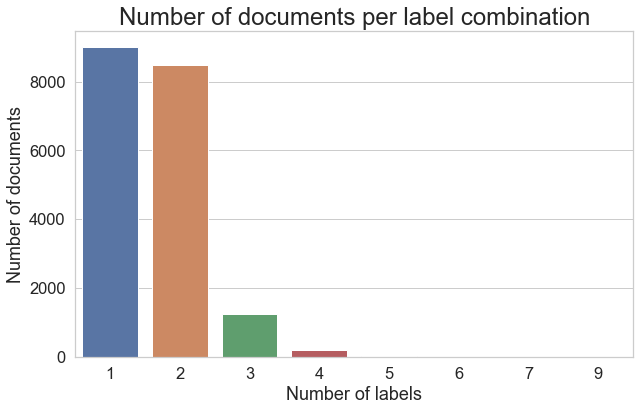

In [28]:
show_barplot(x=label_df_pivot['number_of_labels'].value_counts().index,
             y=label_df_pivot['number_of_labels'].value_counts().values,
             title="Number of documents per label combination",
             xlabel='Number of labels',
             ylabel='Number of documents')

Above bar plot shows,
most of the documents have either one or 2 labels associated with them

#### Step 2.4: Create parsing functions to extract paragraph from nested structure

###### Next, we parse the paragraphs from nested structure to extract the raw text. This text will be further used for preprocessing and modelling

In [29]:
##Do paragraph parsing
para_df = paragraph_parser(lines)

In [9]:
para_df.head()

In [36]:
#number of paragraphs:
print('Number of paragraphs:')
para_df['para_num'].sum()

Number of paragraphs:


601424

In [32]:
#Merge label_df with para_df
label_df=pd.merge(label_df,para_df,on=['documentId'],how='left')

In [13]:
del label_df['value']
label_df.head()

###### Step 2.5 Let's get  Average distribution of words across labels (in top 10 classes)

In [15]:

label_df.loc[label_df['labels'].isin(top_labels)].groupby(['labels'])['raw_word_counts'].mean().sort_values()

We have ~2.5k-5.5k words across labels in increasing order. The paragraph text are quite long across documents!

#### Step 2.6 Let us have a look at word cloud (frequently occuring) words by labels

For "Appeal" label:

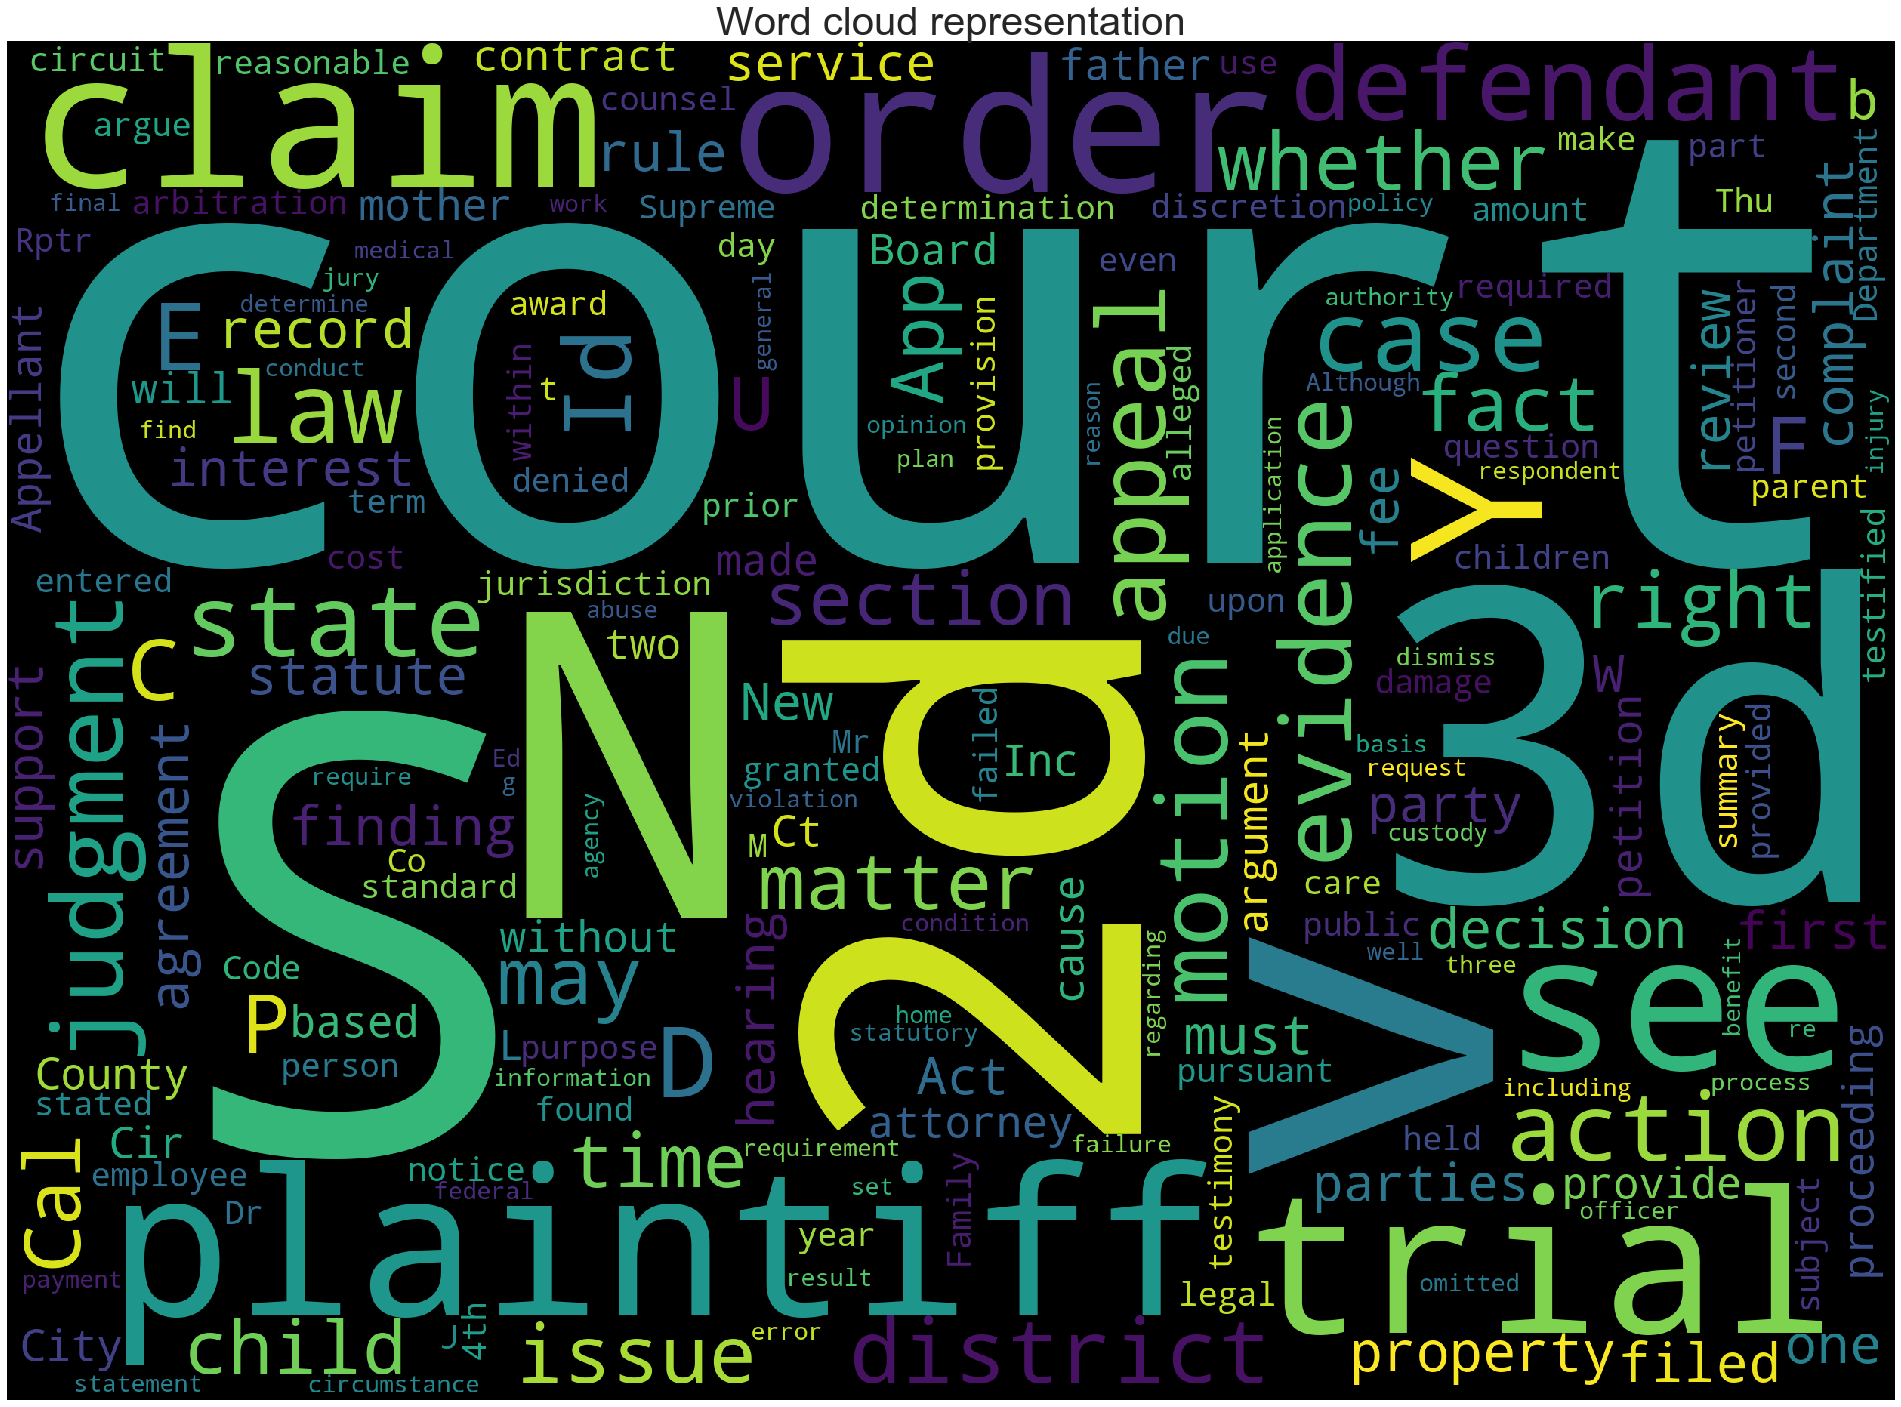

In [40]:
#Show word clouds for a few labels
show_wordcloud(text=label_df.loc[label_df['labels']=='Appeal']['para_text'].values)

Few key words for Appeal are: <br>
 --> court, claim, defendant, see, plaintiff <br>
 --> Section related 2d, 3d appearing too frequently in the text

In [42]:
#Merge label data with paragraph text
data=pd.merge(label_df_pivot.reset_index(),para_df,on=['documentId'],how='inner')

In [16]:
data.head()

### Step3 Data processing
This section takes care of data processing using a function preprocess_data. Below functionalities are supported- <br>
 - remove contractions
 - remove punctuations
 - remove numbers and keep only words
 - remove stop words
 - lemmatize
 
The utility implementation can be looked up in /src/data/preprocess.py

In [45]:
##this may take quite a while to process depending on computation resources
data = preprocess_data(df=data,col='para_text')

In [21]:
data.head()

In [51]:
#compute # of words in preprocessed text
data['preprocessed_word_counts'] = data['preprocessed_text'].apply(word_counts)

In [52]:
data[['raw_word_counts','preprocessed_word_counts']].describe()

,raw_word_counts,preprocessed_word_counts
count,18998.000000,18998.000000
mean,2902.794189,1507.795768
std,2902.445872,1525.458934
min,0.000000,0.000000
25%,943.250000,475.000000
50%,2093.000000,1085.000000
75%,3878.000000,2012.000000
max,55494.000000,28310.000000


Number of words post processing almost reduced by half: as per above descriptive stats. <br>
Can be further validated across a few samples

In [22]:
data.head()

#### Let us visualize via word cloud to see the affect of preprocessing 

Below is the word cloud on "Appeal" label for raw texts

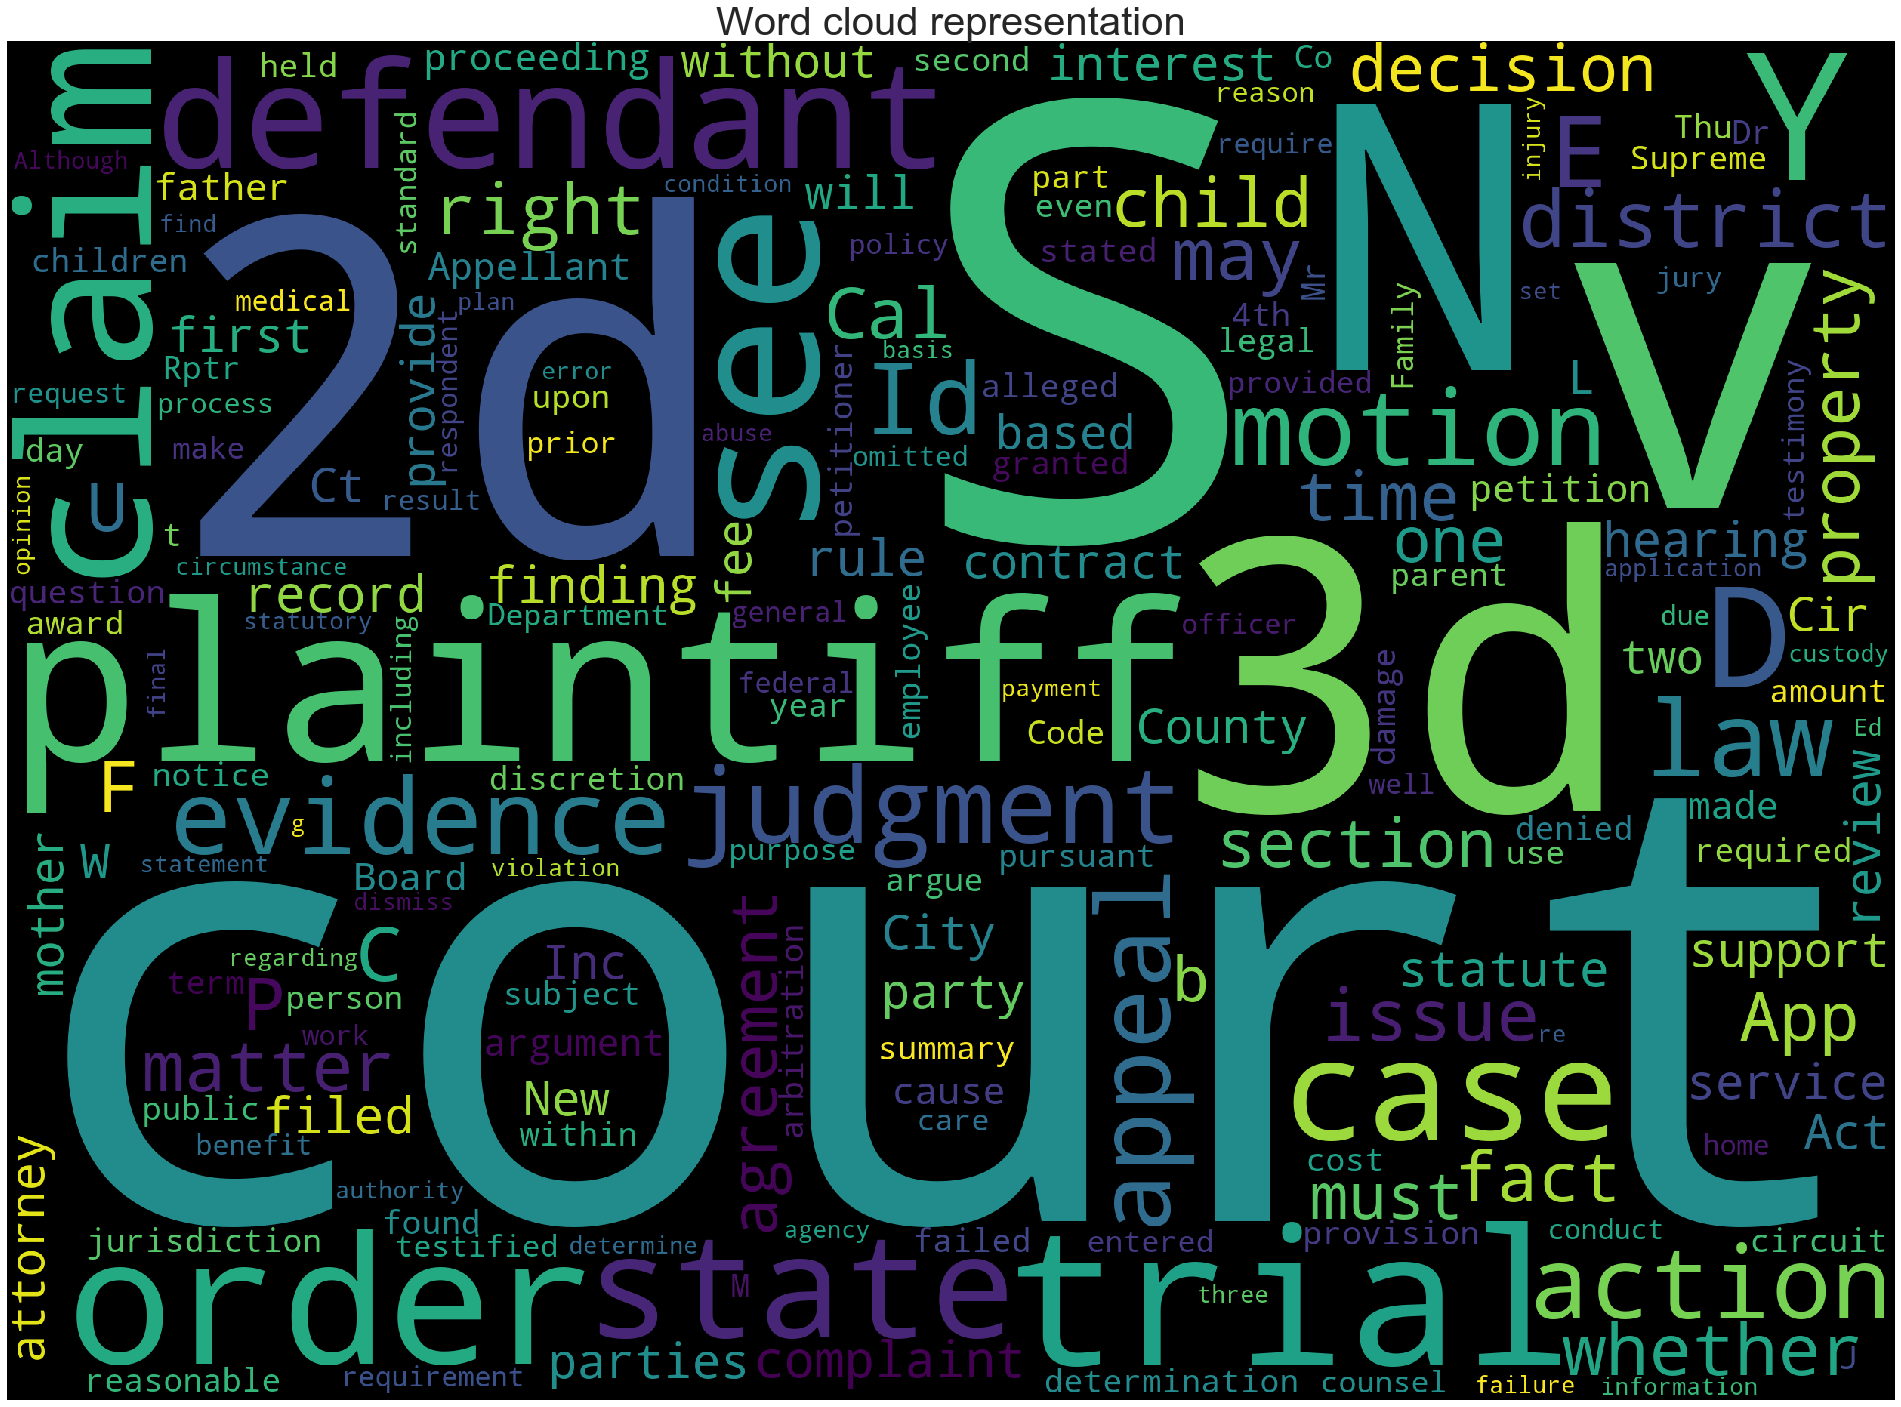

In [54]:
#Word cloud on raw text for "Appeal"
show_wordcloud(text=data.loc[data['Appeal']==1]['para_text'].values)

Below is the word cloud on "Appeal" label for processed texts

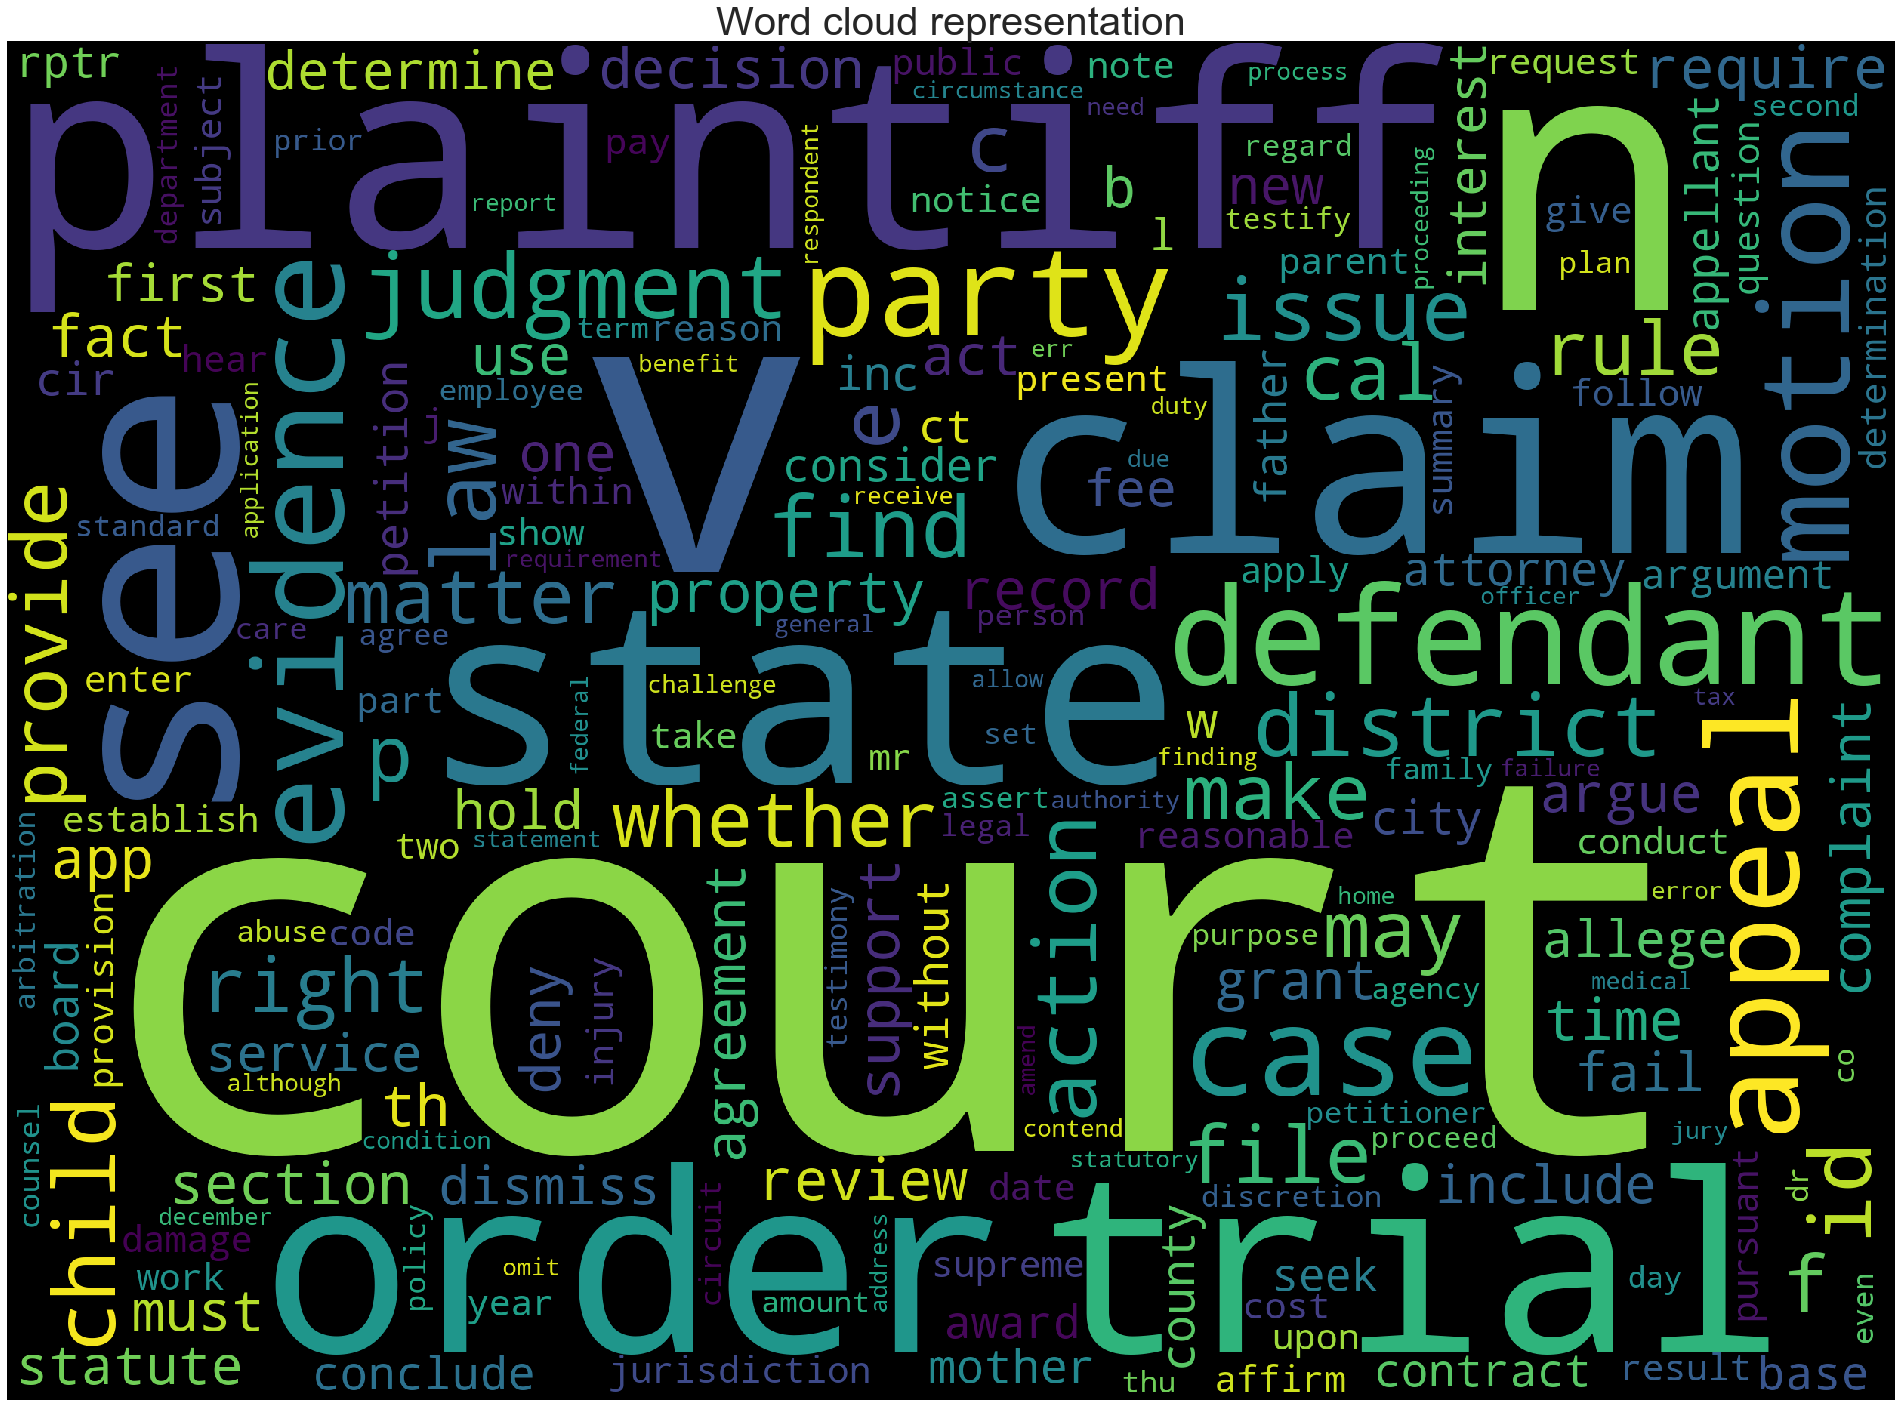

In [55]:
show_wordcloud(text=data.loc[data['Appeal']==1]['preprocessed_text'].values)

##### As seen above, this gives a much cleaner representation. Most of the seemingly less important words like 3d, 2d, Id have been removed 

In [23]:
data.head()

#### Next we subset data to cover top 10 classes. Reasons and futher analysis have been highlighted below

In [57]:
#subset docs that cover top 10 classes
doc_df=label_df[['documentId','labels']].drop_duplicates()
doc_df=doc_df.loc[doc_df['labels'].isin(top_labels)]


In [58]:
#~18k documents have 10 classes
doc_df['documentId'].nunique()

17959

In [59]:
#Total documents post removed of missing labels
data['documentId'].nunique()

18998

In [60]:
#We have 94% of documents that are being covered by 10 documents
print('We have 94% of unique documents that are being covered by 10 documents')
doc_df['documentId'].nunique()/data['documentId'].nunique()

We have 94% of unique documents that are being covered by 10 documents


0.9453100326350142

### Key observation:
For current exploratory modelling exercise we could safely model on 10 labels only instead of ~200 labels.
Below are a few key advantages for focusing on top 10 classes:
-  Getting rid of remaining 190 labels will ensure there is a lower imbalance in dataset. This may help in better model accuracies for the multilabel classification
- We are able to cover 94% of the documents using top 10 classes. This ensures we are keeping most of the data intact with a very minimal (6%) loss of information- which should be acceptable for the sake of initial exploration

### Step4 Modelling excersice begins from here
#### Approach:
This is a multi-label classification problem.                                                                                   
There could be multiple ways to solve this problem such as 
 - OneVsRest strategy:                                                                                                                  This approach divides the target labels into several indenpendent binary classfication tasks. Here each classifier deals with a single class and algorithm assumes they are mutually exclusive
 - Multiclass classification: Target labels are combined into a single class vector
 
One of the good starting point in terms of building baseline exploratory models is to pick OneVsRest strategy. 
Thus in our case, we build 10 classifiers - one each of the labels and evaluate model performances across classifiers

In [62]:
##Subset data such that it has top 10 classes
subset_data =data.loc[data['documentId'].isin(doc_df['documentId'].unique())]

In [63]:
subset_data[:3]
subset_data.shape

(17959, 237)

In [65]:
#train and test split
train, test = train_test_split(subset_data, random_state=80, test_size=0.33, shuffle=True)

X_train = train.preprocessed_text
X_test = test.preprocessed_text
print(X_train.shape)
print(X_test.shape)

(12032,)
(5927,)


Check class distribution for train and test

In [24]:

train[top_labels].sum()*100/train.shape[0]

In [25]:
test[top_labels].sum()*100/test.shape[0]

As seen above, the classes are highly imbalanced. For starters, we could build model on above classes, report a baseline validation metrics and then further explore ways to resolve imbalance problem as next steps

#### The  custom pipeline developed for this scope supports Logsitic Regression and MultiNomial DB only.
The pipeline can be extended to incorporate more models in future

##### We use sklearn's Pipeline functionality to implement modelling exercise. <br>
Reference link: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html <br>
Pipelines are pretty common ways of automating ML processes. <br> 
Since in our usecase we need to build 10 classifiers- Pipeline will allow us to apply desired transformations and build models in an efficient way <br>

##### Below function "build_model_eval" implements LogsitcReg using OneVsRest strategy and generates predicitons on test dataset and computes following evals:
- Accuracy for each classifier
- F1 for each classifier
- Hamming loss for overall multilabel performance <br>
   <sklearn reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html>


In [26]:
test, validation_logref, hamming_loss_logreg = build_model_eval(X_train,X_test,train,test,'LogisticRegression',top_labels, \
                 config['MODEL']['model_path']+'//LogReg')

In [85]:
hamming_loss_logreg

0.04621224902986334

###### Below function "build_model_eval" implements MultinomialNB using OneVsRest strategy and generates predicitons on test dataset and computes evals

In [28]:
test, validation_nb, hamming_loss_nb = build_model_eval(X_train,X_test,train,test,'MultinomialNB',top_labels, \
                 config['MODEL']['model_path']+'//NB')

In [87]:
hamming_loss_nb

0.08655306225746584

##### By this step: model pkls have been saved in specified directory


###### Step5. Report validation metrics

In [111]:
hamming_df=pd.DataFrame([hamming_loss_logreg,hamming_loss_nb],index=['LogReg','NB'],columns=['hamming_loss'])
hamming_df.to_csv(output_path+ '//Hamming_loss.csv',index=False)

In [105]:
hamming_df

,hamming_loss
LogReg,0.046212
NB,0.086553


Hamming loss is lesser for Logstic Regression than NB. Thus logstic regression is better as compared to later.


In [106]:
##f1 and accuracy
validation_df1 = pd.concat([pd.DataFrame(validation_logref,columns=['model_name','label','accuracy','f1']),pd.DataFrame(validation_nb,columns=['model_name','label','accuracy','f1'])])

In [112]:
validation_df1.to_csv(output_path+ '//F1_accuracy_OneVsRest.csv',index=False)

Validation stats of F1 and accuracy indicate- how each classifier has performed across classes. <br>
Since its a multi-class and higly imbalanced datset f1 score is a good metric to compare across different classes.


In [30]:
validation_df1

##### Since predict functions of sklearn takes 0.5 as default threshold, we could use predict_proba instead and tweak thresholds to see we can further improve f1 score


In [110]:
#we finally export predictions output
test.to_csv(output_path+ '//test_predictions.csv',index=False)